## Project: Airline passenger satisfaction.
In this project I am trying to find what factors are highly correlated to a satisfied (or dissatisfied) passenger.

In [58]:
# Importing the modules.
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelBinarizer
from sklearn import set_config
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, precision_recall_curve, confusion_matrix, classification_report, f1_score
from sklearn.metrics import average_precision_score

In [59]:
# Setting the paths.
dir_path = os.getcwd()
data_path = os.path.join(dir_path, 'input')

In [60]:
# Importing the datas.
raw_train = pd.read_csv(os.path.join(data_path, 'train.csv'))
raw_test = pd.read_csv(os.path.join(data_path, 'test.csv'))

In [61]:
# Checking the shapes.
print('Raw train shape:', raw_train.shape)
print('Raw test shape:', raw_test.shape)

Raw train shape: (103904, 25)
Raw test shape: (25976, 24)


In [62]:
# Important notes.
#-----------------
# An unsatisfied customer cannot be classified as satified and hence I will concentrate more on precision.

# Selecting ML algorithm on the basis of limited resource and size of the data.
# 1) Logistic Regression.
# 2) Stochastic Gradient Descent Classifier.

# But for fun I will use Random Forest Classifier.

In [63]:
# Describing the data.
raw_train.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [64]:
# Checking data types.
raw_train.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [65]:
# Dropping unwanted columns.
raw_train.drop(columns = 'Unnamed: 0', inplace = True)
raw_test.drop(columns = 'Unnamed: 0', inplace = True)

In [66]:
# Checking for balanced data.
raw_train.satisfaction.value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

In [67]:
# Fairly balanced data.

### EDA

In [68]:
# Check null values in target feature.
print('Null values in target feauture are:', raw_train.satisfaction.isnull().sum())

Null values in target feauture are: 0


In [69]:
# Columns more than 25% null values.
train_null_data25 = raw_train.isnull().sum()/len(raw_train)*100
train_null_cols25 = train_null_data25[train_null_data25 > 25].keys().to_list()

test_null_data25 = raw_test.isnull().sum()/len(raw_train)*100
test_null_cols25 = test_null_data25[test_null_data25 > 25].keys().to_list()

In [70]:
print('Columns more than 25% null values in training data are:', train_null_cols25)
print('Columns more than 25% null values in testing data are:', train_null_cols25)

Columns more than 25% null values in training data are: []
Columns more than 25% null values in testing data are: []


In [71]:
# Validating zero values.
train_zero_data = (raw_train == 0).sum()
train_zero_cols = train_zero_data[train_zero_data > 0].keys().to_list()

In [72]:
print('Columns with zero values are:\n', train_zero_cols)

Columns with zero values are:
 ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [73]:
# for col in train_zero_cols:
#     print(raw_train[col].value_counts(), '\n')

In [74]:
# All the above columns can have zero values.

In [75]:
# Checking for low var columns.
raw_train.var()

id                                   1.403537e+09
Age                                  2.284621e+02
Flight Distance                      9.943027e+05
Inflight wifi service                1.763131e+00
Departure/Arrival time convenient    2.325854e+00
Ease of Online booking               1.957004e+00
Gate location                        1.632315e+00
Food and drink                       1.767657e+00
Online boarding                      1.821174e+00
Seat comfort                         1.739992e+00
Inflight entertainment               1.776864e+00
On-board service                     1.659857e+00
Leg room service                     1.730816e+00
Baggage handling                     1.394533e+00
Checkin service                      1.601227e+00
Inflight service                     1.382184e+00
Cleanliness                          1.722060e+00
Departure Delay in Minutes           1.461602e+03
Arrival Delay in Minutes             1.497588e+03
dtype: float64

In [76]:
# Checking null values.
null_data = raw_train.isnull().sum()
train_null_cols = null_data[null_data > 0].keys().to_list()

null_data = raw_test.isnull().sum()
test_null_cols = null_data[null_data > 0].keys().to_list()

In [77]:
print('Null columns in training data are:', train_null_cols)
print('Null columns in testing data are:', test_null_cols)

Null columns in training data are: ['Arrival Delay in Minutes']
Null columns in testing data are: ['Arrival Delay in Minutes']


In [78]:
# Notes
# 1) Appending 'Arrival Delay in Minutes' with mode.

In [79]:
# Splitting the data.
seed = 42
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = seed)

for train_idx, holdout_idx in splitter.split(raw_train, raw_train.satisfaction):
    train_data, holdout_data = raw_train.loc[train_idx], raw_train.loc[holdout_idx]
    
train_data.reset_index(drop = True, inplace = True)                    
holdout_data.reset_index(drop = True, inplace = True)

In [80]:
# Proportions.
train_data.satisfaction.value_counts()/len(train_data)

neutral or dissatisfied    0.566666
satisfied                  0.433334
Name: satisfaction, dtype: float64

In [81]:
# Proportions.
holdout_data.satisfaction.value_counts()/len(holdout_data)

neutral or dissatisfied    0.566671
satisfied                  0.433329
Name: satisfaction, dtype: float64

In [82]:
# Filling NaN values.
train_data['Arrival Delay in Minutes'].fillna(train_data['Arrival Delay in Minutes'].mode()[0], inplace = True)
holdout_data['Arrival Delay in Minutes'].fillna(holdout_data['Arrival Delay in Minutes'].mode()[0], inplace = True)
raw_test['Arrival Delay in Minutes'].fillna(raw_test['Arrival Delay in Minutes'].mode()[0], inplace = True)

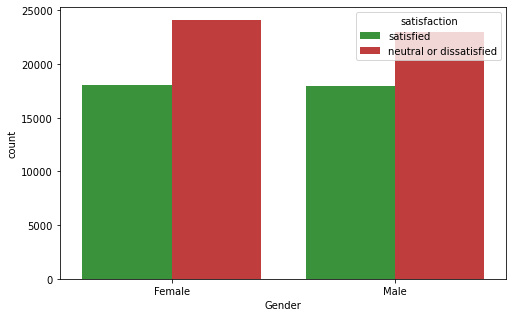

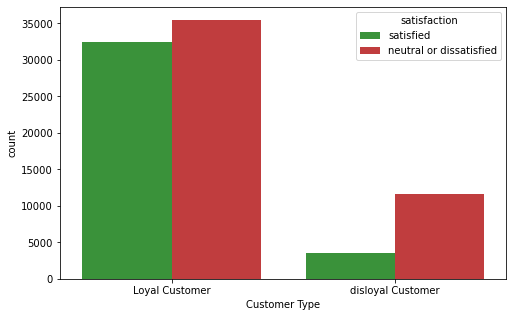

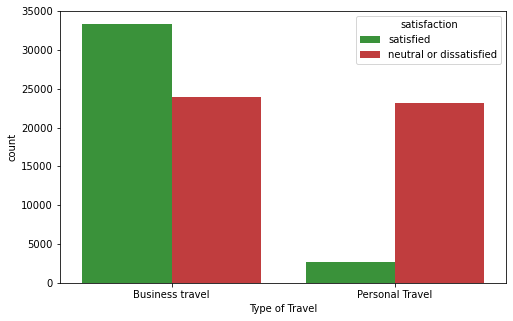

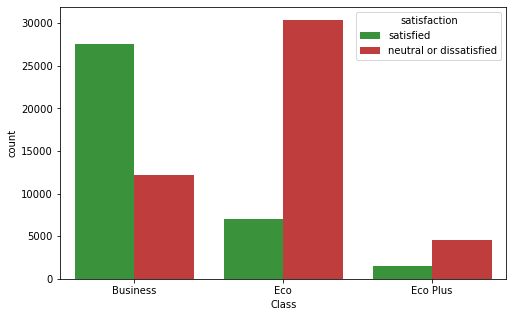

In [84]:
# Exploring the data.
for col in train_data.select_dtypes(include = 'object'):
    if col != 'satisfaction':
        plt.figure(figsize = (8, 5))
        sb.countplot(x = col, data = train_data, hue = 'satisfaction', palette = ['tab:green', 'tab:red'])
        plt.show()

In [85]:
# Business class customers are more satisfied.

In [215]:
# Checking the mean values().
train_data.groupby('satisfaction').mean()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
satisfaction,,,,,,,,,,,,,,,,,,,
neutral or dissatisfied,64841.478328,37.560958,925.861824,2.400207,3.126359,2.544112,2.976275,2.976478,2.651121,3.040909,2.896013,3.019440,2.972938,3.376979,3.048960,3.404831,2.941162,8.977313,9.300595
satisfied,66022.363191,41.765540,1520.529195,3.165685,2.977288,3.036925,2.979318,3.506686,4.028455,3.959826,3.965946,3.867498,3.820073,3.964902,3.640145,3.976186,3.736563,6.987730,6.713299


In [216]:
# Checking the mean values().
train_data.groupby(['satisfaction', 'Class']).mean()

id        Age  Flight Distance  \
satisfaction            Class                                                
neutral or dissatisfied Business  66893.956829  39.090354      1418.783011   
                        Eco       64291.348941  36.846810       752.208435   
                        Eco Plus  63011.953734  38.242367       765.640676   
satisfied               Business  70622.773846  42.690902      1777.351917   
                        Eco       52183.505135  38.483256       688.457062   
                        Eco Plus  45636.660907  40.077034       670.311735   

                                  Inflight wifi service  \
satisfaction            Class                             
neutral or dissatisfied Business               2.390459   
                        Eco                    2.403837   
                        Eco Plus               2.402067   
satisfied               Business               2.949937   
                        Eco                    3.862926   
                        Eco Plus               3.888409   

                                  Departure/Arrival time convenient  \
satisfaction            Class                                         
neutral or dissatisfied Business                           2.855660   
                        Eco                                3.211930   
                        Eco Plus                           3.280178   
satisfied               Business                           2.927864   
                        Eco                                3.155083   
                        Eco Plus                           3.055436   

                                  Ease of Online booking  Gate location  \
satisfaction            Class                                             
neutral or dissatisfied Business                2.750829       2.974621   
                        Eco                     2.459361       2.978405   
                        Eco Plus                2.557069       2.966416   
satisfied               Business                2.985436       2.985209   
                        Eco                     3.244828       2.955202   
                        Eco Plus                3.008639       2.984161   

                                  Food and drink  Online boarding  \
satisfaction            Class                                       
neutral or dissatisfied Business        2.892203         2.782400   
                        Eco             3.015340         2.605353   
                        Eco Plus        2.942226         2.605214   
satisfied               Business        3.505025         4.132021   
                        Eco             3.471052         3.688049   
                        Eco Plus        3.710583         3.709143   

                                  Seat comfort  Inflight entertainment  \
satisfaction            Class                                            
neutral or dissatisfied Business      2.997645                2.679662   
                        Eco           3.063701                2.982424   
                        Eco Plus      3.004227                2.897839   
satisfied               Business      4.096219                4.055221   
                        Eco           3.480726                3.627325   
                        Eco Plus      3.688265                3.909287   

                                  On-board service  Leg room service  \
satisfaction            Class                                          
neutral or dissatisfied Business          2.894383          2.833682   
                        Eco               3.072716          3.025299   
                        Eco Plus          2.998121          2.996008   
satisfied               Business          4.038495          3.988357   
                        Eco               3.331150          3.277869   
                        Eco Plus          3.215983          3.248380   

                                  Baggage handling  C

In [86]:
# Selecting only Grade columns to explore the data.
remove_cols = ['Age', 'id', 'Departure/Arrival time convenient', 
               'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']
grade_cols = set(train_data.select_dtypes(exclude = 'object').keys()) - set(remove_cols)

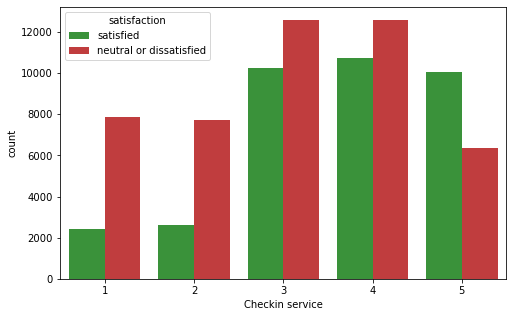

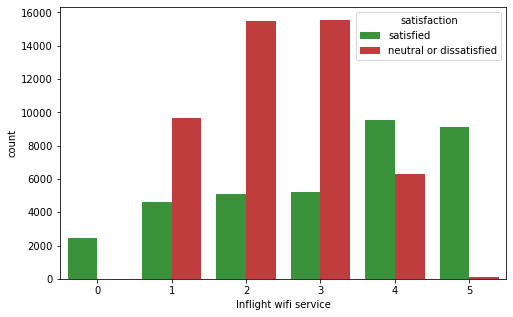

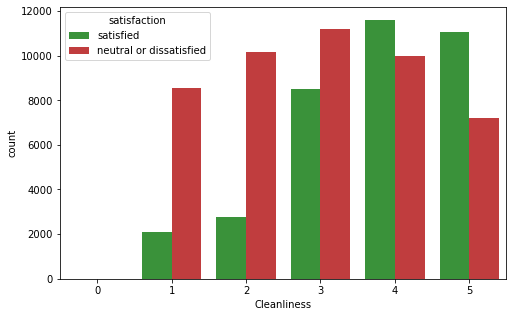

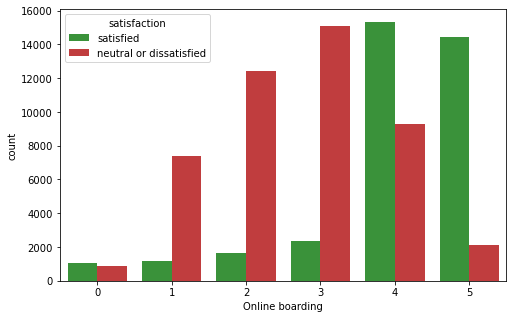

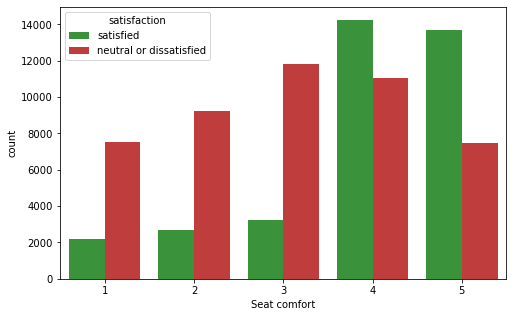

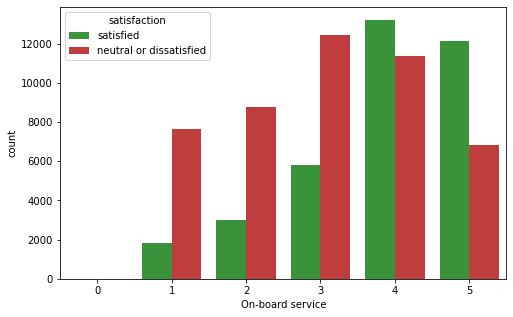

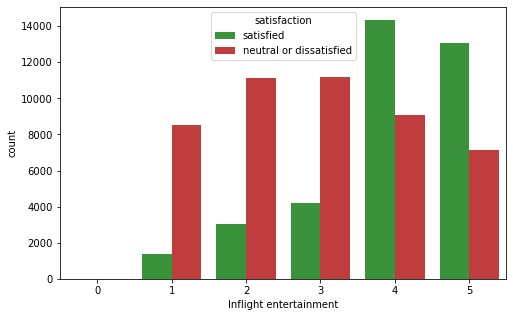

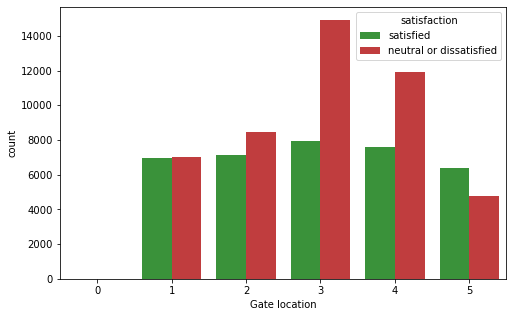

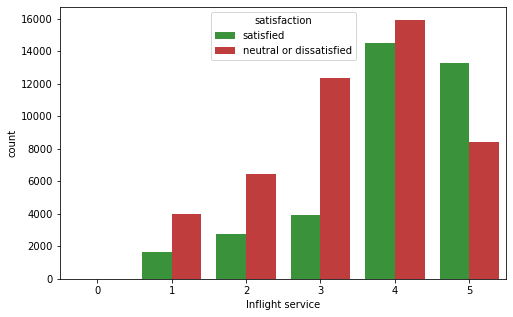

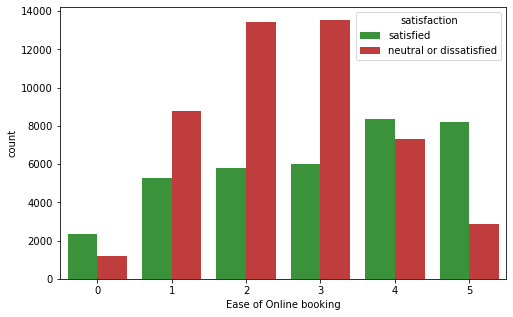

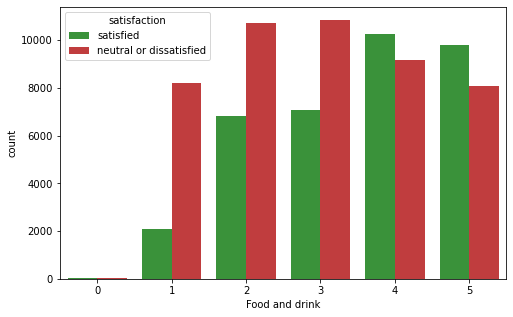

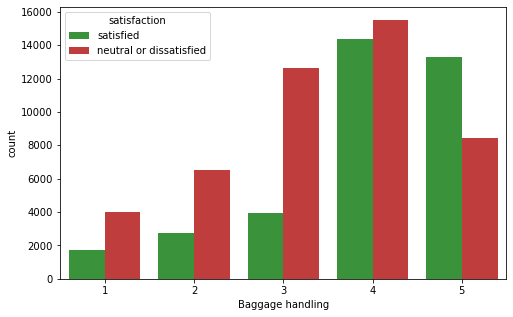

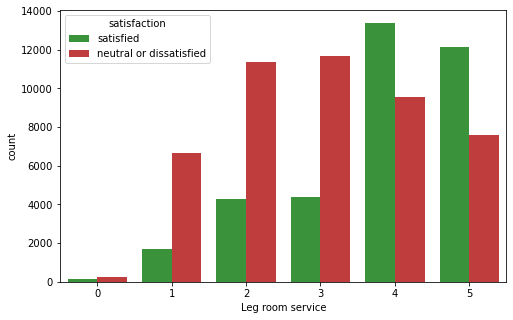

In [87]:
for col in grade_cols:
    if col != 'satisfaction':
        plt.figure(figsize = (8, 5))
        sb.countplot(x = col, data = train_data, hue = 'satisfaction', palette = ['tab:green', 'tab:red'])
        plt.show()

In [88]:
# Grades with 4 and 5 tend to satisfy the customers.

In [89]:
# Developing model for Logistic Regression
# Assumption checks for Logistic Regression
# 1) Data should be normally distributed.
# 2) No outliers.
# 3) No Multicollinearity.
# 4) Mean error should be zero.

In [90]:
# 1) Data should be normally distributed.

# Hypothesis
# H0 --> data is normally distributed.
# H1 --> data is not normally distributed.

ND_cols = []                                                      # List of normally distributed columns.
NND_cols = []                                                     # List of not normally distributed columns.

for col in train_data.select_dtypes(exclude = 'object').keys():
    pval = stats.normaltest(train_data[col])[-1]                  # Checking for normal distribution.
    
    if pval > 0.05:
        ND_cols.append(col)                                       # Appending the values.
    else:
        NND_cols.append(col)                                      # Appending the values.

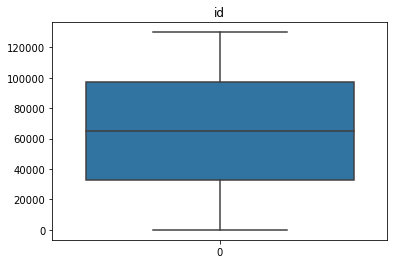

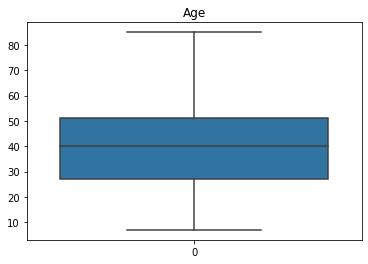

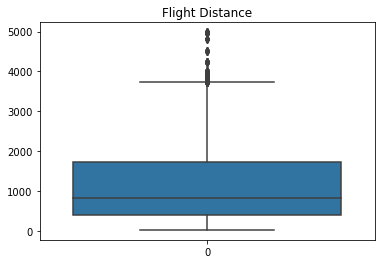

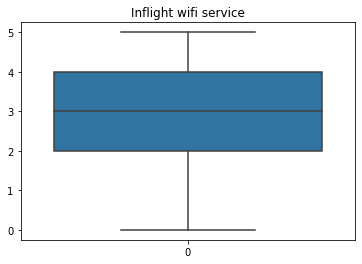

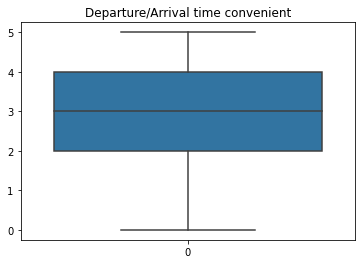

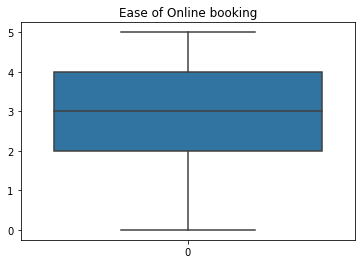

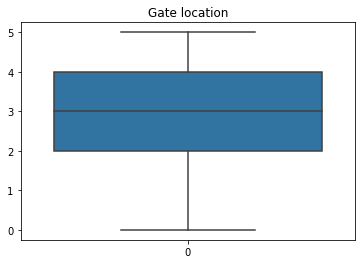

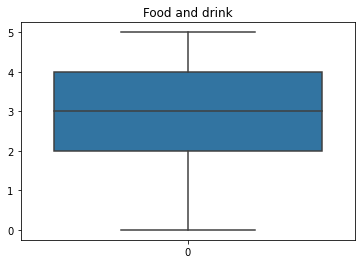

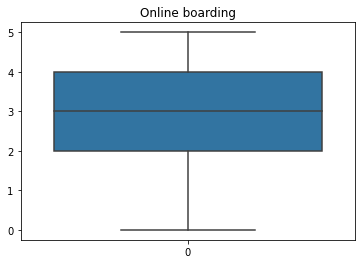

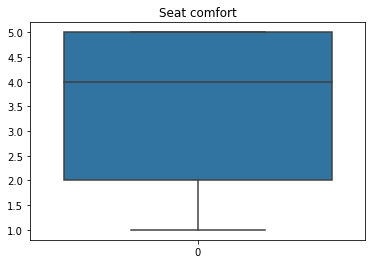

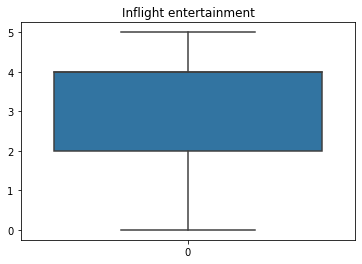

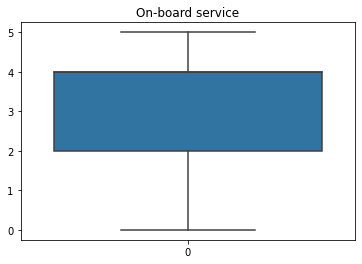

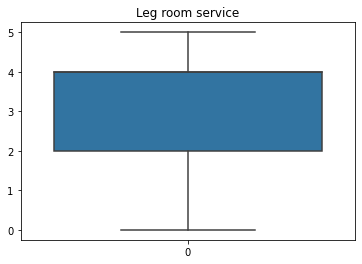

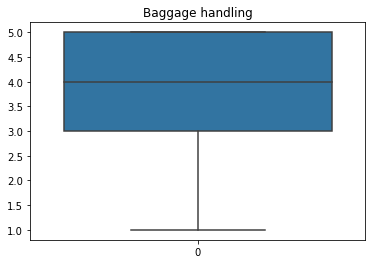

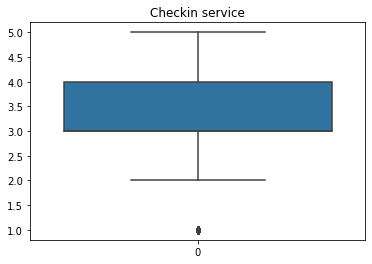

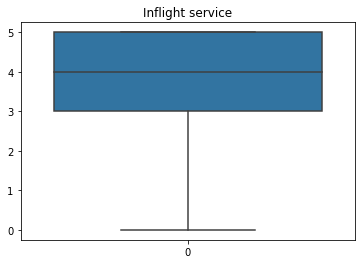

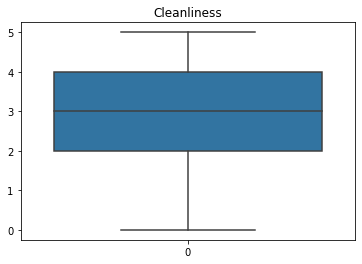

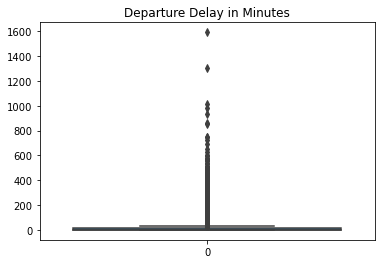

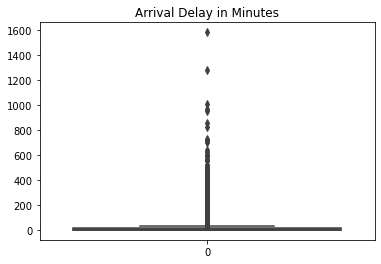

In [91]:
# 2) Checking outliers.
for col in train_data.select_dtypes(exclude = 'object').keys().to_list():
    sb.boxplot(data = train_data[col])
    plt.title(col)
    plt.show()

In [92]:
# Outliers are present.
# Removing the outliers by using z-score.

def remove_outliers(data):
    '''Removes outliers using z score.
    
    Parameter
    ---------
    data: data from which the outliers are to be removed.
    
    Return
    ------
    Returns a data frame with outliers removed.
    '''
    
    # Creating a copy of the data.
    temp_data = data.copy()
    
    # Calculating z score for each column and removing the outliers.
    for col in temp_data.select_dtypes(exclude = 'object').keys().to_list():
        # Calculating z score.
        temp_data['z'] = np.absolute((temp_data[col] - temp_data[col].mean())/temp_data[col].std())   
        temp_data = temp_data[temp_data['z'] < 3]         # Selecting values within 3 standard deviation.                   
        
    temp_data.drop(columns = ['z'], inplace = True)       # Dropping the z column.
    
    print('Shape of the data before removing outliers is:', data.shape)
    print('Shape of the data after removing outliers is:', temp_data.shape)
    
    return temp_data                                      # Returning the data frame.

In [93]:
# Removing the outliers.
print('Training data')
train_data = remove_outliers(train_data)

print('\n')
print('Holdout data')
holdout_data = remove_outliers(holdout_data)

Training data
Shape of the data before removing outliers is: (83123, 24)
Shape of the data after removing outliers is: (78817, 24)


Holdout data
Shape of the data before removing outliers is: (20781, 24)
Shape of the data after removing outliers is: (19731, 24)


In [94]:
# 3) Checking multicollinearity.
corr_matrix = train_data.select_dtypes(exclude = 'object').corr()

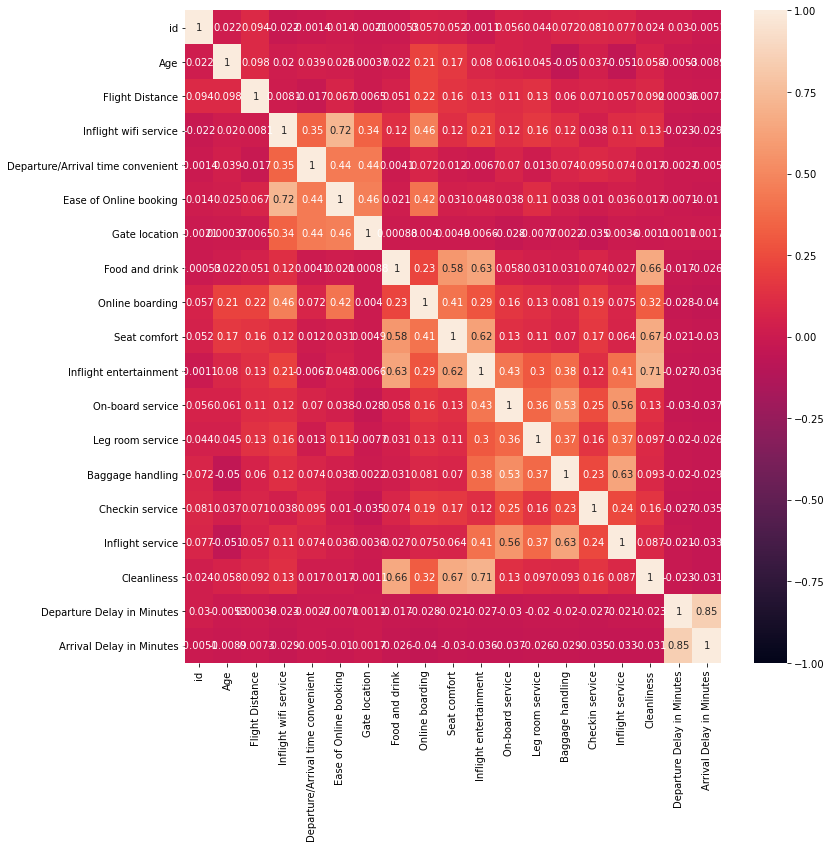

In [95]:
plt.figure(figsize = (12, 12))
sb.heatmap(corr_matrix, vmax = 1, vmin = -1, annot = True)
plt.show()

In [42]:
# Cleanliness is very important.

In [96]:
# Power transform columns.
power_trans_cols = set(NND_cols) - grade_cols                             # Columns on which power transformer will be applied.
power_trans_cols.remove('id')                                             # Removing 'id' column.

# Onehot encoding columns.
ohe_cols = raw_train.select_dtypes(include = 'object').keys().to_list()   # Columns on which one hot encoding will be applied.
ohe_cols.remove('satisfaction')                                           # Removing 'satisfaction' column.

# Standard scaling columns.
stdscale_cols = (set(raw_train.columns) - set(ohe_cols)) - set(['id', 'satisfaction']) - power_trans_cols

# Converting to list for Pipeline.
power_trans_cols = list(power_trans_cols)
ohe_cols = list(ohe_cols)
stdscale_cols = list(stdscale_cols)

In [97]:
# Creating Pipeline.
power_pipeline = Pipeline([('powertranspipe', PowerTransformer(standardize = True))])  # Power transform pipeline.
stdscale_pipeline = Pipeline([('stdscalepipe', StandardScaler())])                     # Standard scaler pipeline.
ohe_pipeline = Pipeline([('ohepipe', OneHotEncoder(drop = 'first'))])                  # One hot encoding pipeline.

# Creating column transformer.
my_transformer = ColumnTransformer([('powertrans', power_pipeline, power_trans_cols),  
                                    ('stdtrans', stdscale_pipeline, stdscale_cols),
                                    ('ohetrans', ohe_pipeline, ohe_cols)])

In [98]:
# Visualizing the Transformer.
set_config(display = 'diagram')
my_transformer

ColumnTransformer(transformers=[('powertrans',
                                 Pipeline(steps=[('powertranspipe',
                                                  PowerTransformer())]),
                                 ['Arrival Delay in Minutes',
                                  'Departure/Arrival time convenient',
                                  'Departure Delay in Minutes', 'Age',
                                  'Flight Distance']),
                                ('stdtrans',
                                 Pipeline(steps=[('stdscalepipe',
                                                  StandardScaler())]),
                                 ['Checkin service', 'Inflight wifi service',
                                  'Cleanliness', 'Online boarding',
                                  'Seat comfort', 'On-board service',
                                  'Inflight entertainment', 'Gate location',
                                  'Inflight service', 'Ease of Online booking',
                                  'Food and drink', 'Baggage handling',
                                  'Leg room service']),
                                ('ohetrans',
                                 Pipeline(steps=[('ohepipe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Gender', 'Customer Type', 'Type of Travel',
                                  'Class'])])

In [99]:
# Splitting the features and target.
#-----------------------------------
train_features = train_data.drop(columns = ['satisfaction', 'id'])          # Training features.
y_train = train_data.satisfaction                                           # Training target.

holdout_features = holdout_data.drop(columns = ['satisfaction', 'id'])      # Holdout features.
y_holdout = holdout_data.satisfaction                                       # Holdout target.

test_features = raw_test.drop(columns = ['id'])                             # Test features.
test_id = raw_test.id                                                       # Test id.

In [100]:
# Applying the transformations.
trans_train = my_transformer.fit_transform(train_features)
trans_holdout = my_transformer.transform(holdout_features)
trans_test = my_transformer.transform(test_features)

In [101]:
# Extracting all the columns.
ohe_mod_cols = my_transformer.named_transformers_['ohetrans'].named_steps['ohepipe'].get_feature_names(ohe_cols)
columns = power_trans_cols + stdscale_cols + list(ohe_mod_cols)

In [102]:
# Making data frames.
trained_df = pd.DataFrame(trans_train, columns = columns)
holdout_df = pd.DataFrame(trans_holdout, columns = columns)
test_df = pd.DataFrame(trans_test, columns = columns)

In [103]:
# Saving the datas.
trained_df.to_csv(os.path.join(data_path, 'trained_df.csv'), index = False)
y_train.to_csv(os.path.join(data_path, 'y_train.csv'), index = False)

holdout_df.to_csv(os.path.join(data_path, 'holdout_df.csv'), index = False)
y_holdout.to_csv(os.path.join(data_path, 'y_holdout.csv'), index = False)

test_df.to_csv(os.path.join(data_path, 'test_df.csv'), index = False)
test_id.to_csv(os.path.join(data_path, 'test_id.csv'), index = False)

In [104]:
# Label Binarizer for calculating average precision.
label = LabelBinarizer()
y_train_binary = label.fit_transform(y_train).ravel()
y_holdout_binary = label.transform(y_holdout).ravel()

In [105]:
# Helper function.
def model_cv(classifier, scoring_mtd, cv):
    '''Function for finding the best model based on cross validation.
    
    Parameter
    ---------
    classifier: ML algorithm.
    scoring_mtd: Specify scoring method for evaluation.
    cv: Number of folds.
    
    Return
    ------
    Prints scores based on given scoring method.
    '''
    
    # Applying cross val score.
    scores = cross_val_score(classifier, trained_df, 
                             y_train_binary, scoring = scoring_mtd,
                             cv = cv, n_jobs = -1)
    
    print('Average precision score for {} is {:.4f}'.format(classifier, np.mean(scores)))

In [106]:
# Finding the best models.
# Models.
lr_clf = LogisticRegression()
sgd_clf = SGDClassifier()
rf_clf = RandomForestClassifier()

# List of classifiers.
classifiers = [lr_clf, sgd_clf, rf_clf]

# Scoring method.
scoring_mtd = 'average_precision'               # Since I am concentrating on precision I will use 'average_precision.'

# Applying the function to get the best model.
for classifier in classifiers:
    model_cv(classifier, scoring_mtd, 5)

Average precision score for LogisticRegression() is 0.9325
Average precision score for SGDClassifier() is 0.9289
Average precision score for RandomForestClassifier() is 0.9922


In [107]:
# Choosing Logistic Regression.

# Hyperparameter Tuning.

def random_holdout(holdout_df, percent_of_holdout):
    '''Random Hold out data for tuning. The data is randomized to avoid any bias.
    
    Parameter
    ---------
    holdout_df: Hold out data.
    percent_of_holdout: Percent of random data to be returned.
    
    Return
    ------
    Returns randomized data for tuning.
    '''
    
    size = np.int(len(holdout_df)*(percent_of_holdout/100))       # Size of the data to be returned.
    idx = np.random.choice(len(holdout_df), size = size)          # Randomly selecting index.
    hold_out_set = holdout_df.iloc[idx, :]                        # Selecting feature data based on random index.
    y_hold_out_set = y_holdout.iloc[idx]                          # Selecting target data based on random index.
    
    return hold_out_set, y_hold_out_set                           # Returning the values.


def tuning(classifier, hold_out_set, y_hold_out_set):
    '''Helper function for Hyperparameter tuning.
    
    Parameter
    ---------
    classifier: ML algorithm.
    hold_out_set: Hold out feature data.
    y_hold_out_set: Hold out target data.
    
    Return
    ------
    Prints Precision and F1 scores.
    '''
    
    classifier.fit(trained_df, y_train)               # Fitting the training data.
    
    train_pred = classifier.predict(trained_df)       # Predicting on training data.
    holdout_pred = classifier.predict(hold_out_set)   # Predicting on holdout data.

    # Printing the scores.
    print('Training data metrics')
    print('---------------------')
    print('Precision Score on training set is:', 
          np.round(precision_score(train_pred, y_train, average = 'micro'), 4))
    print('F1 Precision Score on training set is:', 
          np.round(f1_score(train_pred, y_train, average = 'micro'), 4))
    
    print('\n')
    print('Testing data metrics')
    print('---------------------')
    print('Precision Precision Score on holdout set is:', 
          np.round(precision_score(holdout_pred, y_hold_out_set, average = 'micro'), 4))
    print('F1 Precision Score on holdout set is:', 
          np.round(f1_score(holdout_pred, y_hold_out_set, average = 'micro'), 4))
    print('---------------------------------------------------------')

In [108]:
# Tuning Logistic Regression.
lr_clf = LogisticRegression()

percent_of_holdout = 70                                                        # Using 70% holdout data.
hold_out_set, y_hold_out_set = random_holdout(holdout_df, percent_of_holdout)  # Getting the holdout data.
tuning(lr_clf, hold_out_set, y_hold_out_set)                                   # Applying the tuning fuction.

Training data metrics
---------------------
Precision Score on training set is: 0.8751
F1 Precision Score on training set is: 0.8751


Testing data metrics
---------------------
Precision Precision Score on holdout set is: 0.8821
F1 Precision Score on holdout set is: 0.8821
---------------------------------------------------------


In [ ]:
# Model is underfitting.

In [110]:
# To overcome underfitting, increasing the value of C.

C_values = range(2, 10, 1)                                                        # Range of C values. 
percent_of_holdout = 70                                                           # Using 70% holdout data.

for c in C_values:
    print('C value:', c)
    
    lr_clf = LogisticRegression(C = c)
    
    hold_out_set, y_hold_out_set = random_holdout(holdout_df, percent_of_holdout) # Getting the holdout data.
    tuning(lr_clf, hold_out_set, y_hold_out_set)                                  # Applying the tuning fuction.
    print('\n')

C value: 2
Training data metrics
---------------------
Precision Score on training set is: 0.8751
F1 Precision Score on training set is: 0.8751


Testing data metrics
---------------------
Precision Precision Score on holdout set is: 0.8804
F1 Precision Score on holdout set is: 0.8804
---------------------------------------------------------


C value: 3
Training data metrics
---------------------
Precision Score on training set is: 0.8751
F1 Precision Score on training set is: 0.8751


Testing data metrics
---------------------
Precision Precision Score on holdout set is: 0.8767
F1 Precision Score on holdout set is: 0.8767
---------------------------------------------------------


C value: 4
Training data metrics
---------------------
Precision Score on training set is: 0.8751
F1 Precision Score on training set is: 0.8751


Testing data metrics
---------------------
Precision Precision Score on holdout set is: 0.8787
F1 Precision Score on holdout set is: 0.8787
----------------------

In [ ]:
# Not much improvement.

In [119]:
# Try changing the threshold using precision recall curve.

lr_clf = LogisticRegression()
lr_clf.fit(trained_df, y_train)    

# Using predict_proba to get the probability values for precision_recall_curve.
train_pred = lr_clf.predict_proba(trained_df)

#**Using Positive class for calculation**(probas_pred = train_pred[:, 1])
precision, recall, thresholds = precision_recall_curve(y_true = y_train_binary, 
                                                       probas_pred = train_pred[:, 1])

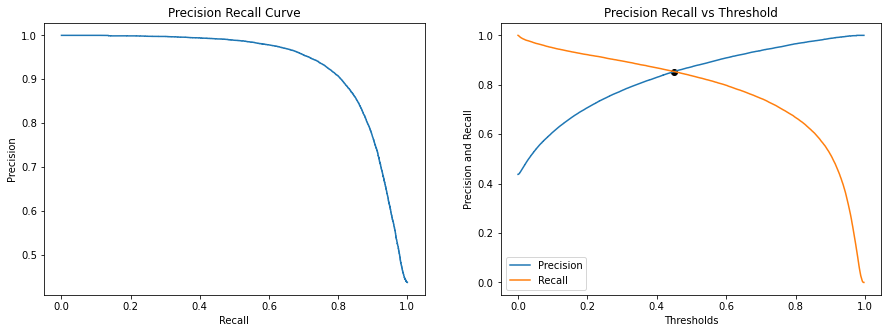

In [139]:
# Finding the index where precision and recall are same.
threshold_idx = np.where(precision == recall)[0][0]

# Plotting.
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(recall[: -1], precision[: -1])
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.subplot(122)
plt.plot(thresholds, precision[: -1], label = 'Precision')
plt.plot(thresholds, recall[: -1], label = 'Recall')
plt.scatter(thresholds[44340], precision[: -1][44340], color = 'k')
plt.title('Precision Recall vs Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Precision and Recall')
plt.legend()
plt.show()

In [140]:
# I am choosing a threshold value of '0.7' as it will increase the precision.

In [161]:
# precision_recall_values fuction.
def precision_recall_values(threshold):
    '''Prints the precision and recall values at a given threshold value.
    
    Parameter
    ---------
    threshold: Threshold at which the values needs to be printed.
    
    Return
    ------
    Prints Precision and Recall.
    '''
    
    idx = np.where(thresholds >= threshold)[0][0]
    print('Threshold value:', threshold)
    print('---------------------')
    print('Precision value:', np.round(precision[idx], 4))
    print('Recall value:', np.round(recall[idx], 4))

In [162]:
# Applying the function.
precision_recall_values(0.7)

Threshold value: 0.7
---------------------
Precision value: 0.9385
Recall value: 0.745


In [165]:
# Training on complete data with threshold as '0.7'.

X = pd.concat([trained_df, holdout_df], axis = 0)     # Concatenating trained_df and holdout_df.
y = pd.concat([y_train, y_holdout], axis = 0)         # Concatenating y_train and y_holdout.

X.reset_index(drop = True, inplace = True)            # Resetting the index.
y.reset_index(drop = True, inplace = True)            # Resetting the index.

In [168]:
# Saving the data.
X.to_csv(os.path.join(data_path, 'X.csv'), index = False)
y.to_csv(os.path.join(data_path, 'y.csv'), index = False)

In [169]:
# Fitting on the entire data.
lr_clf = LogisticRegression()
lr_clf.fit(X, y)               # Fitting the data.

In [203]:
# Predicting on the test data.
test_pred = lr_clf.predict_proba(test_df)

In [204]:
# Mapping to get the final values.
# Specifying the threshold.
threshold = 0.7

# Map function.
mapper = np.vectorize(lambda x: lr_clf.classes_[1] if x > threshold else lr_clf.classes_[0])

# Applying the map function on the test_pred.
y_test = mapper(test_pred[:, 1])

In [206]:
# Saving the predicted values.
y_test = pd.DataFrame(data = y_test, columns = ['satisfaction'])
y_test.to_csv(os.path.join(data_path, 'y_test.csv'), index = False)

In [ ]:
# Insights.
# From the data few pattern that I found were: -
# 1) Business class customers are more satisfied.
# 2) Business travel customers are more satisfied.
# 3) Customer satisfaction doesn't depend on Gender.
# 4) Customers provided with services with 4-5 grade tend to be more satisfied.
# 5) Cleanliness has high influence.

# Prescription.
# All the provided services should be of 4-5 grade.
# Concentrate on Cleanliness and Online boarding.
# Concentrate on Eco class and personal travel as they are most unsatisfied customer.